In [1]:
# for nbconvert
import os
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mannwhitneyu as u_test, kruskal, wilcoxon
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

In [2]:
score_names = ['Strongly \nDisagree (1)', 'Disagree (2)', 'Somewhat \nDisagree (3) ', 'Neutral (4)',
                        'Somewhat \nAgree (5)', 'Agree (6)', 'Strongly \nAgree (7)']

def format_p_value(p_value, precision=2):
    p_value_string = f"{p_value:.{precision}f}"[1:]
    
    if p_value < 10**(-precision):
        p_value_string = f"<.{1:0{precision}d}"

    return p_value_string

def format_stat_test(result):
    statistic = result.statistic
    p_value = result.pvalue
    p_value_string = format_p_value(p_value)

    return f"Statistic: {statistic:>9,.2f} - P-Value: {p_value_string:>4}"


def format_model_name(model_name):
    return model_name.upper().replace('_', '-')

def plot_realism_by_scene(all_scores, output_path=None):
    video_realism = dict()

    for video in videos:
        target_id = f"{gt}-{video}"

        for model in [gt] + models:
            question_id = f"{model}-{video}-realism"

            scores = all_scores[question_id].copy()

            if target_id in video_realism:
                video_realism[target_id] = pd.concat((video_realism[target_id], scores))
            else:
                video_realism[target_id] = scores


    video_realism_df = pd.DataFrame.from_dict(video_realism, orient='index').T

    ax = video_realism_df.boxplot()
    ax.set_title(f"Realism of All Conditions by Scene\n"
                 f"'The 3D effect in this video is realistic.'")

    ax.set_ylabel("Score")
    ax.set_yticklabels(['', *score_names, ''], rotation=30)
    ax.set_ylim(bottom=.7, top=7.3)
    ax.set_xlabel("Scene")

    ax.set_xticklabels(videos)

    ax.grid(axis='x')

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, transparent=True)

    plt.show()

def plot_realism_by_model(all_scores, statistical_test=None, output_path=None):
    model_realism = dict()

    for model in models + [gt]:
        target_id = model

        for video in videos:
            question_id = f"{target_id}-{video}-realism"

            scores = all_scores[question_id].copy()

            if target_id in model_realism:
                model_realism[target_id] = pd.concat((model_realism[target_id], scores), ignore_index=True)
            else:
                model_realism[target_id] = scores

    model_realism_df = pd.DataFrame.from_dict(model_realism, orient='index').T

    plt.figure(figsize=(8, 6))
    ax = model_realism_df.boxplot(medianprops={'linewidth': 2, 'color': 'green'})
    ax.set_title(f"Realism of 3D Effect by Model\n"
                 f"'The 3D effect in this video is realistic.'")

    ax.set_ylabel("Score")
    ax.set_ylim(bottom=.7, top=7.3)
    ax.set_yticks(range(9))
    ax.set_yticklabels(['', *score_names, ''], rotation=30)
    ax.set_xlabel("Model")

    def stylise_model_name(model_name):
        if len(model_name) > 15:
            model_name = model_name.replace('-', '\n')
        else:
            model_name = model_name.replace('-', ' ')

        model_name = model_name.replace('_', '-')

        return model_name.upper()

    ax.set_xticklabels(map(stylise_model_name, model_realism_df.columns))

    ax.grid(axis='x')


    if statistical_test is not None:
        for (i, j), p_value in statistical_test:
            # Statistical Significance
            x1, x2 = i, j

            if abs(i - j) == 1:
                offset = 0.
            else:
                offset = .9

                ax.set_ylim(bottom=.7, top=8.3)
                ax.set_yticks(range(10))
                ax.set_yticklabels(['', *score_names, '', ''], rotation=30)

            anchor_point = model_similarity_df.max().max()
            y, h, color = anchor_point + offset + .25, .25, 'k'
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=color)
            u = (x1 + x2) * .5
            v = y + h + .1
            p_value_str = '<.001' if p_value < .001 else ('<.01' if p_value < .01 else f'={f"{p_value:.2f}"[1:]}')
            p_value_str = f"P{p_value_str}"
            ax.text(u, v, f"{p_value_str}", ha='center', va='bottom', color=color)


    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, transparent=True, dpi=300)


    plt.show()

def plot_realism_by_rater(scores, output_path=None):
    realism_ratings_df = pd.DataFrame.from_dict(scores, orient='index')
    flattened_rater_scores = dict()

    for rater in realism_ratings_df.index.unique():
        flattened_rater_scores[rater] = realism_ratings_df.loc[rater].values.flatten()
    realism_ratings_df = pd.DataFrame.from_dict(flattened_rater_scores)

    ax = realism_ratings_df.boxplot()
    ax.set_title(f"Realism Scores by Rater\n"
                 f"'The 3D effect in this video is realistic.'")

    ax.set_ylabel("Score")
    ax.set_yticklabels(['', *score_names, ''], rotation=30)
    ax.set_ylim(bottom=.7, top=7.3)
    ax.set_xlabel("Rater")
    ax.set_xticklabels(range(1, len(realism_ratings_df.columns) + 1))

    ax.grid(axis='x')

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, transparent=True)


    plt.show()

def plot_scores_by_task(scores, title, question, output_path=None):
    def stylise_task_names(task_name):
        parts = task_name.split('-')[:-1]

        return ' '.join(parts).upper()

    scores_df = pd.DataFrame.from_dict(scores, orient='index').T
    ax = scores_df.boxplot(vert=False)

    ax.set_title(f"{title}\n"
                 f"'{question}'")
    ax.set_ylabel("Task")
    ax.set_yticklabels(map(stylise_task_names, scores_df.columns), rotation=30)
    ax.set_xlabel("Score")
    ax.set_xticklabels(['', *score_names, ''], rotation=30)

    if output_path is not None:
        plt.savefig(output_path, transparent=True)

    plt.show()

def plot_similarity_scores_by_scene(similarity_scores, output_path=None):
    video_similarity = dict()

    for video in videos:
        target_id = f"{gt}-{video}"

        for model in models:
            question_id = f"{gt}-{model}-{video}-similarity"

            scores = similarity_scores[question_id].copy()

            if target_id in video_similarity:
                video_similarity[target_id] = pd.concat((video_similarity[target_id], scores))
            else:
                video_similarity[target_id] = scores


    video_similarity_df = pd.DataFrame.from_dict(video_similarity)

    ax = video_similarity_df.boxplot()
    ax.set_title(f"Similarity of All Conditions by Video\n"
                 f"'These two videos are similar.'")

    ax.set_ylabel("Score")
    ax.set_yticklabels(['', *score_names, ''], rotation=30)
    ax.set_ylim(bottom=.7, top=7.3)
    ax.set_xlabel("Scene")

    ax.set_xticklabels(videos)

    ax.grid(axis='x')

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, transparent=True)


    plt.show()
    
def plot_similarity_scores_by_model(similarity_scores, statistical_test=None, output_path=None):
    model_similarity = dict()

    for model in models:
        target_id = f"{gt}-{model}"

        for video in videos:
            question_id = f"{target_id}-{video}-similarity"

            scores = similarity_scores[question_id].copy()

            if target_id in model_similarity:
                model_similarity[target_id] = pd.concat((model_similarity[target_id], scores))
            else:
                model_similarity[target_id] = scores

    model_similarity_df = pd.DataFrame.from_dict(model_similarity)

    plt.figure(figsize=(8, 6))
    ax = model_similarity_df.boxplot(medianprops={'linewidth': 2, 'color': 'green'})
    ax.set_title(f"Similarity Scores by Model Pair\n"
                 f"'These two videos are similar.'")

    ax.set_ylabel("Score")
    ax.set_yticklabels(['', *score_names, ''], rotation=30)
    ax.set_ylim(bottom=.7, top=7.3)
    ax.set_yticks(range(9))
    ax.set_xlabel("Model Pair")

    def stylise_pair_name(model_name):
        if len(model_name) > 15:
            model_name = model_name.replace('-', '\n')
        else:
            model_name = model_name.replace('-', ' ')

        model_name = model_name.replace('_', '-')

        return model_name.upper()

    pair_ids = [f"{gt.upper()}\n{stylise_pair_name(model)}" for model in models]
    ax.set_xticklabels(pair_ids)

    ax.grid(axis='x')

    if statistical_test is not None:
        for (i, j), p_value in statistical_test:
            # Statistical Significance
            x1, x2 = i, j

            if abs(i - j) == 1:
                offset = 0.
            else:
                offset = .9

                ax.set_ylim(bottom=.7, top=8.3)
                ax.set_yticks(range(10))
                ax.set_yticklabels(['', *score_names, '', ''], rotation=30)

            anchor_point = model_similarity_df.max().max()
            y, h, color = anchor_point + offset + .25, .25, 'k'
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=color)
            u = (x1 + x2) * .5
            v = y + h + .1
            p_value_str = '<.001' if p_value < .001 else ('<.01' if p_value < .01 else f'={f"{p_value:.2f}"[1:]}')
            p_value_str = f"P{p_value_str}"
            ax.text(u, v, f"{p_value_str}", ha='center', va='bottom', color=color)

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, transparent=True, dpi=300)


    plt.show()

def plot_similarity_scores_by_rater(similarity_scores, output_path=None):
    similarity_scores_df = pd.DataFrame.from_dict(similarity_scores)

    ax = similarity_scores_df.T.boxplot()
    ax.set_title(f"Similarity Scores by Rater\n"
                 f"'These two videos are similar.'")

    ax.set_ylabel("Score")
    ax.set_yticklabels(['', *score_names, ''], rotation=30)
    ax.set_ylim(bottom=.7, top=7.3)
    ax.set_xlabel("Rater")
    ax.set_xticklabels(range(1, len(similarity_scores_df) + 1))

    ax.grid(axis='x')

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, transparent=True)


    plt.show()


def convert_to_scores(df, columns, scale_range, answer_prefix):
    output = dict()

    for col in columns:
        data = None

        for i in range(1, scale_range + 1):
            full_col = f"{answer_prefix}{col}.{i}"

            if data is None:
                data = df[full_col].copy(deep=True)
            data[df[full_col]] = i

        output[col] = data.astype(int)

    return output


def get_gt_realism_scores(df, videos):
    gt_realism_data = dict()
    cols_to_remove = []

    for col in df.columns:
        for video in videos:
            task_id = f"gt-{video}"

            if task_id in col and 'realism' in col:
                rating = col[-1]
                gt_id = col.replace(f"Answer.{task_id}-", '').split('-')[0]
                scores = df[col].copy() * int(rating)

                dest_col = f"{task_id}-realism-{gt_id}"

                if dest_col not in gt_realism_data:
                    gt_realism_data[dest_col] = scores
                else:
                    gt_realism_data[dest_col] = gt_realism_data[dest_col].add(scores, fill_value=0)

                cols_to_remove.append(col)

    gt_realism_scores = dict()

    for key in gt_realism_data:
        # This line gets rid of the unique id at the end
        task_id = '-'.join(key.split('-')[:-1])

        if task_id in gt_realism_scores:
            gt_realism_scores[task_id] = pd.concat([gt_realism_scores[task_id], gt_realism_data[key]])
        else:
            gt_realism_scores[task_id] = gt_realism_data[key].copy()

    for key in gt_realism_scores:
        cleaned_series = gt_realism_scores[key].dropna().sort_index()
        # For some reason, pandas treats the scores as strings instead of numbers?!?
        cleaned_series = cleaned_series.astype(int)

        gt_realism_scores[key] = cleaned_series


    return gt_realism_scores, cols_to_remove

In [3]:
csv_path = "./mturk_results_2.csv"

In [4]:
output_path = "study_results/"
os.makedirs(output_path, exist_ok=True)
stats_file_path = os.path.join(output_path, 'stats.csv')

class Models:
    gt = 'gt'
    enb0_hu_rw = 'enb0_hu_rw'
    flat = 'flat'
    enb0_hu = 'enb0_hu'
    senet_hu = 'senet_hu'

df = pd.read_csv(csv_path)
df.columns = df.columns.str.replace('reside', 'hu')
df.columns = df.columns.str.replace('-random_weights', '_rw')
# Replace model names with new format
df.columns = df.columns.str.replace('hu_enb0_rw', Models.enb0_hu_rw)
df.columns = df.columns.str.replace('hu_enb0', Models.enb0_hu)
df.columns = df.columns.str.replace('hu_senet', Models.senet_hu)

gt = Models.gt
models = [Models.enb0_hu_rw, Models.flat, Models.enb0_hu, Models.senet_hu]
videos = list(map(lambda x: f"{x:06d}", [0, 30, 66, 260]))
num_tasks = len(models) * len(videos)
scale_range = 7

answer_prefix = 'Answer.'
metadata = [col for col in df.columns if not col.startswith(answer_prefix)]
demographics = [
    'age', 'agree-to-terms.on', 'gender.female',
    'gender.male', 'gender.other', 'good-vision.no', 'good-vision.yes'
]

exit_survey = ['feedback-comments', 'feedback-realism']
realism_answers = [f"{model}-{video}-realism" for model in models for video in videos]
gt_realism_answers = [col for col in df.columns for video in videos if f"gt-{video}" in col and 'realism' in col]
similarity_answers = [f"{gt}-{model}-{video}-similarity" for model in models for video in videos]

similarity_scores = convert_to_scores(df, similarity_answers, scale_range, answer_prefix)
realism_scores = convert_to_scores(df, realism_answers, scale_range, answer_prefix)
gt_realism_scores, columns_to_remove = get_gt_realism_scores(df, videos)
merged_realism_scores = {**realism_scores, **gt_realism_scores}

alpha = .05

In [5]:
gt_realism_scores.keys()

dict_keys(['gt-000000-realism', 'gt-000030-realism', 'gt-000066-realism', 'gt-000260-realism'])


# Lots of Box Plots
## Notes
- P-Values: the threshold for statistical significance is .05
- Models:
    - GT: The ground truth depth maps captured with a Kinect sensor.
    - FLAT: The flat depth maps.
    - HU_ENB0: A small depth estimation model (~5 million parameters) that uses EfficientNet-B0 as its encoder.
    - HU_ENB0_RW: The same model as HU_ENB0 except it has not been trained and uses random weights.
    - HU_SENET: A large depth estimation model (~157 million parameters) that uses Squeeze-Excitation layers in a ResNet like architecture.
- Expected ranking of models (best to worst):
    1.  GT
    2.  HU_SENET
    3.  HU_ENB0
    4.  FLAT
    5.  HU_ENB0_RW
- There were:
    - 4 scenes.
    - 4 conditions (each model paired with the ground truth).
    - 20 participants.
    - 20 responses for the similarity of each combination of condition pairs and scenes.
    - 20 responses for the realism of each unique pair of models (excluding ground truth) and scenes.
    - 80 responses for realism of for each pair of ground truth model and scenes (the ground truth model is shown in every video pair).

Participants were asked to spend up to 2 minutes on each task. They had to watch each video at least 3 times through which means they have to spend at least 15 seconds per task before answering any questions.
The fact that all participants averaged close to and above one minute would suggest that they were taking their time to answer questions.

Mean Time per Task: 72.2 seconds

Mean Time per Task by Participant:
        WorkTimeInSeconds
Rater                   
1                70.4375
2                64.1875
3                89.0000
4                53.0625
5                89.4375
6                47.8125
7                76.4375
8                91.8125
9                90.3750
10               58.5625
11               91.8750
12               89.8750
13               69.0625
14               78.2500
15               74.9375
16               36.6875
17               90.6250
18               74.8125
19               63.6250
20               43.3125


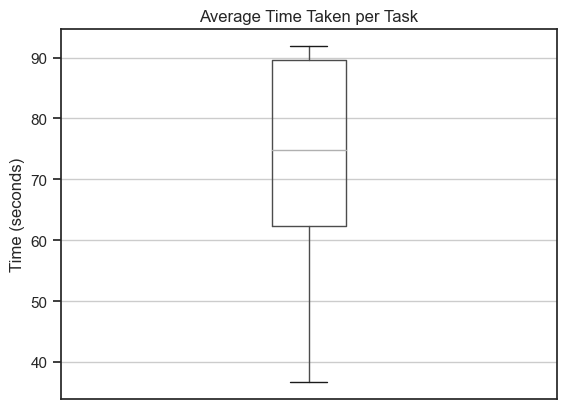

In [6]:
worker_time_df = df[['WorkerId', 'WorkTimeInSeconds']]
worker_time_df = worker_time_df.drop('WorkerId', axis='columns')
worker_time_df = worker_time_df.reset_index(drop=True).rename_axis('Rater')
worker_time_df.index = worker_time_df.index + 1

print(f"Mean Time per Task: {worker_time_df.mean().sum().item() / num_tasks:.1f} seconds\n")
print("Mean Time per Task by Participant:\n", worker_time_df / num_tasks)
ax = (worker_time_df / num_tasks).boxplot()
ax.set_title('Average Time Taken per Task')
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('')
ax.set_xticks([])
plt.show()

## Demographics

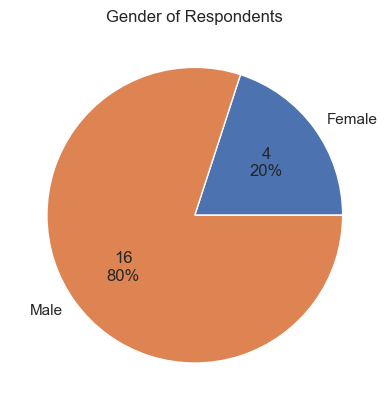

In [7]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

gender_df = df[f"{answer_prefix}gender.male"].copy()
gender_df[df[f"{answer_prefix}gender.male"]] = 'Male'
gender_df[df[f"{answer_prefix}gender.female"]] = 'Female'
gender_df[df[f"{answer_prefix}gender.other"]] = 'Other'
gender_df = pd.DataFrame(gender_df)
gender_df.columns = ['gender']
ax = gender_df.groupby('gender').size().plot.pie(autopct=label_function)
ax.set_title('Gender of Respondents')
ax.set_ylabel('', size=22)
plt.savefig(os.path.join(output_path, 'demo_gender.png'), transparent=True)
plt.show()

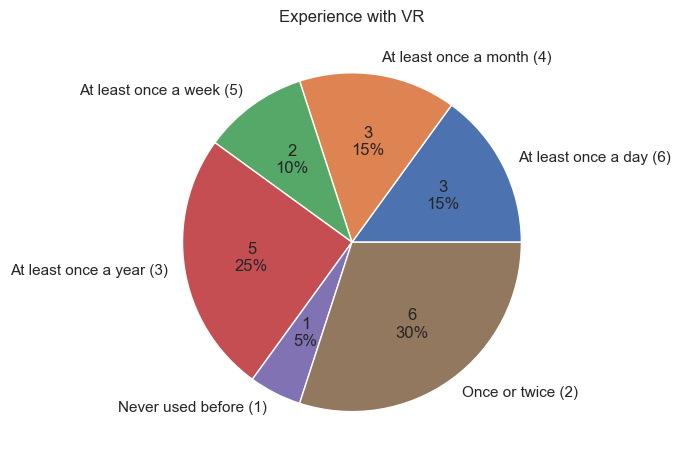

VR Experience by Rater:
                vr-experience
6       Never used before (1)
10          Once or twice (2)
3           Once or twice (2)
5           Once or twice (2)
19          Once or twice (2)
8           Once or twice (2)
16          Once or twice (2)
14   At least once a year (3)
12   At least once a year (3)
9    At least once a year (3)
4    At least once a year (3)
2    At least once a year (3)
18  At least once a month (4)
7   At least once a month (4)
17  At least once a month (4)
11   At least once a week (5)
15   At least once a week (5)
1     At least once a day (6)
13    At least once a day (6)
20    At least once a day (6)


In [8]:
vr_experience_scores = convert_to_scores(df, ['vr-experience'], 5, answer_prefix)
vr_experience_scores = pd.DataFrame.from_dict(vr_experience_scores)
vr_experience_scores.index = vr_experience_scores.index + 1
vr_experience_scores = vr_experience_scores.sort_values('vr-experience')
vr_experience_scores[vr_experience_scores == 0] = 'Never used before (1)'
vr_experience_scores[vr_experience_scores == 1] = 'Once or twice (2)'
vr_experience_scores[vr_experience_scores == 2] = 'At least once a year (3)'
vr_experience_scores[vr_experience_scores == 3] = 'At least once a month (4)'
vr_experience_scores[vr_experience_scores == 4] = 'At least once a week (5)'
vr_experience_scores[vr_experience_scores == 5] = 'At least once a day (6)'
ax = vr_experience_scores.groupby('vr-experience').size().plot.pie(autopct=label_function)
ax.set_title('Experience with VR')
ax.set_ylabel('', size=22)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'demo_vr_experience.png'), bbox_inches='tight', transparent=True)
plt.show()

print("VR Experience by Rater:")
print(vr_experience_scores)

In [9]:
percent_with_normal_correct_vision = df[f"{answer_prefix}good-vision.yes"].mean() * 100
print(f"Percent of Participants with Normal/Corrected Vision: {percent_with_normal_correct_vision:.2f}%")

Percent of Participants with Normal/Corrected Vision: 100.00%


In [10]:
print(f"Age of Participants: {df[f'{answer_prefix}age'].sort_values().values}")
print(f"Mean Age: {df[f'{answer_prefix}age'].sort_values().values.mean()}")
print(f"Median Age: {np.median(df[f'{answer_prefix}age'].sort_values().values)}")

Age of Participants: [20 20 21 25 26 26 26 29 30 32 32 32 33 34 38 39 41 41 43 49]
Mean Age: 31.85
Median Age: 32.0


## How Similar to the Ground Truth are the Various Models?
Below is a plot of the responses for each video pair.
Each boxplot shows the distribution of all the participants' ratings for a given video.
There's quite a bit going on in this one, but it seems that participants are still struggling to distinguish between the ground truth and the other models.
The main trend that we see is that the random depth maps are consistently rated lower than the other models.


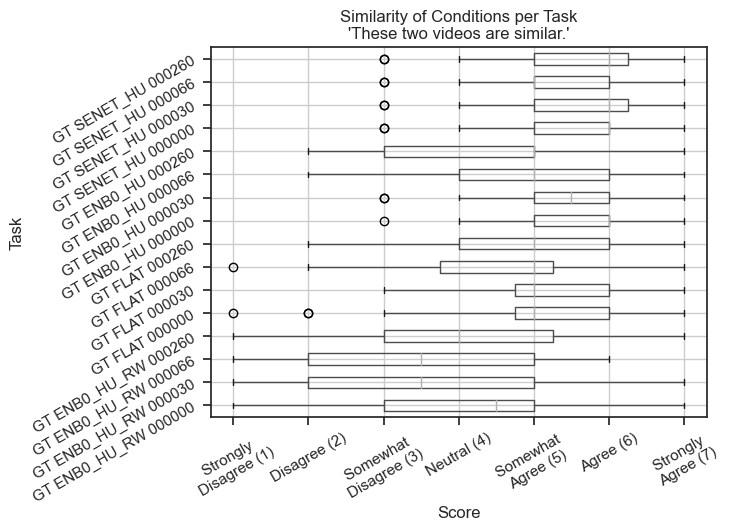

In [11]:
plot_scores_by_task(similarity_scores, title='Similarity of Conditions per Task', question='These two videos are similar.', output_path=os.path.join(output_path, 'similarity_task.png'))

## Do participants perceive a difference in quality between different models?
Yes. For example, participants consistently rated the random depth maps to be of lower quality than the other depth map sources.

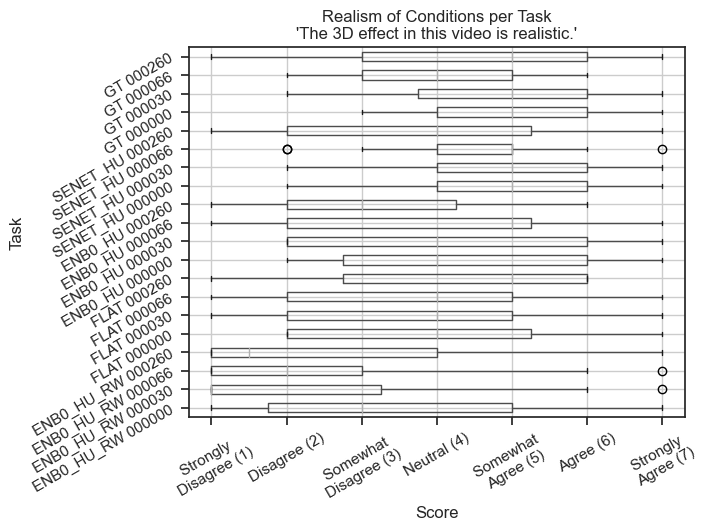

In [12]:
plot_scores_by_task(merged_realism_scores, title='Realism of Conditions per Task', question='The 3D effect in this video is realistic.', output_path=os.path.join(output_path, 'realism_task.png'))

## Are Participants Using the Full Range of Scores?
Participants generally gave higher scores for similarity.
The range of scores varied quite a bit between different participants, some gave scores in a tight range whereas others gave a wide range of scores.

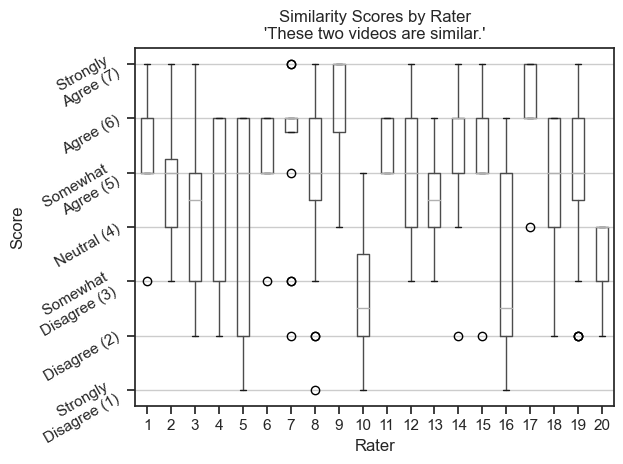

In [13]:
plot_similarity_scores_by_rater(similarity_scores, output_path=os.path.join(output_path, 'similarity_rater.png'))

When it comes to rating the individual videos in terms of realism, participants tend to give lower scores and use the full range of scores.

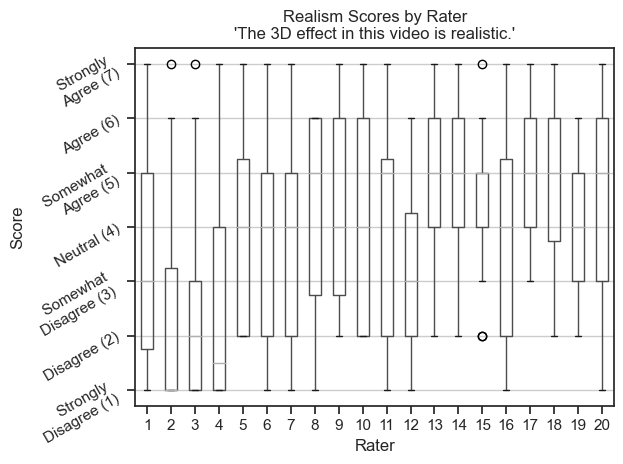

In [14]:
plot_realism_by_rater(merged_realism_scores, output_path=os.path.join(output_path, 'realism_rater.png'))

## Is there a clear ranking between different models?
Looking at the median scores, yes. The ranking is even what we would expect going off the quantitative metrics.
The range of scores still overlap quite a bit between models, but participants do rate the largest model more closely to each other.

Kruskal-Wallis H-test: H=43.02, <.001
Num Tests: 6
Pairwise Mann-Whitney U test by model on similarity. We apply Bonferroni correction which means the threshold for significance is .008 ($\alpha=.05$, 6 tests).
      Model A  Median A   Model B  Median B  U Statistic       P-Value  \
0  ENB0-HU-RW         4      FLAT         5         2151  2.489267e-04   
1  ENB0-HU-RW         4   ENB0-HU         5         1958  1.534662e-05   
2  ENB0-HU-RW         4  SENET-HU         6         1442  9.606403e-10   
3        FLAT         5   ENB0-HU         5         3001  4.831538e-01   
4        FLAT         5  SENET-HU         6         2324  1.974802e-03   
5     ENB0-HU         5  SENET-HU         6         2511  1.470777e-02   

   Significance  
0          True  
1          True  
2          True  
3         False  
4          True  
5         False  


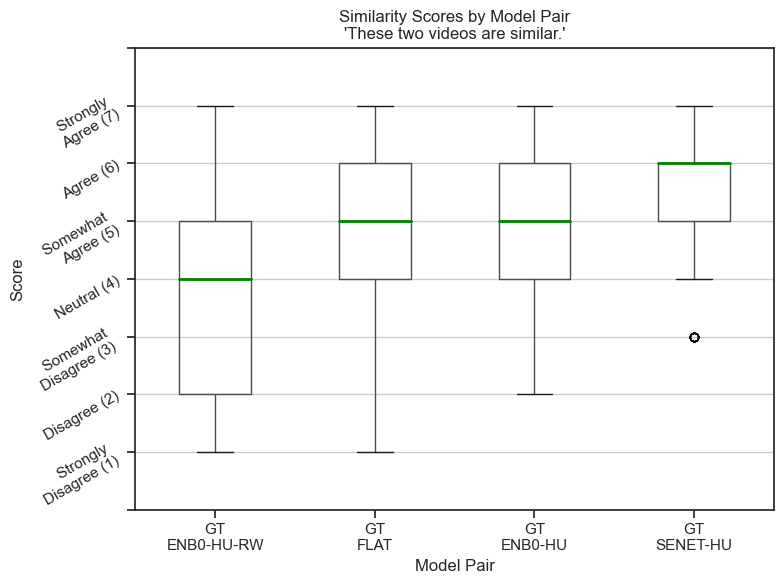

In [15]:
model_similarity = dict()
statistical_test = []

for model in models:
    target_id = f"{gt}-{model}"

    for video in videos:
        question_id = f"{target_id}-{video}-similarity"

        scores = similarity_scores[question_id].copy()

        if target_id in model_similarity:
            model_similarity[target_id] = pd.concat([model_similarity[target_id], scores])
        else:
            model_similarity[target_id] = scores

model_similarity_df = pd.DataFrame.from_dict(model_similarity)

kruskal_result = kruskal(*model_similarity.values())
kruskal_result_text = f"Kruskal-Wallis H-test: H={kruskal_result.statistic:,.2f}, {format_p_value(kruskal_result.pvalue, 3)}"
print(kruskal_result_text)

with open(os.path.join(output_path, 'similarity_model_kruskal.txt'), 'w') as f:
    f.write(kruskal_result_text)

comparisons = [(i, j) for i in range(len(models) - 1) for j in range(i + 1, len(models))]
num_tests = len(comparisons)
print(f"Num Tests: {num_tests}")

model_a = []
median_a = []
model_b = []
median_b = []
statistics = []
p_values = []
significances = []

def compare_u_test(model_i, model_j):
    model_a_name = format_model_name(models[model_i])
    model_b_name = format_model_name(models[model_j])

    video_a = f"{Models.gt}-{models[model_i]}"
    video_b = f"{Models.gt}-{models[model_j]}"
    test_results = u_test(model_similarity_df[video_a], model_similarity_df[video_b])

    p_value = test_results.pvalue

    if p_value < alpha / num_tests:
        statistical_test.append(((model_i + 1, model_j + 1), p_value))

    model_a.append(model_a_name)
    median_a.append(np.median(model_similarity_df[video_a]))
    model_b.append(model_b_name)
    median_b.append(np.median(model_similarity_df[video_b]))
    statistics.append(test_results.statistic)
    p_values.append(test_results.pvalue)
    significances.append(p_value < alpha / num_tests)

for i, j in comparisons:
    compare_u_test(i, j)

stats_df = pd.DataFrame.from_dict({'Model A': model_a, 'Median A': median_a, 'Model B': model_b, 'Median B': median_b, 'U Statistic': statistics, 'P-Value': p_values, 'Significance': significances})

for column in ('U Statistic', 'Median A', 'Median B'):
    stats_df[column] = stats_df[column].astype(int)
    
caption = (f"Pairwise Mann-Whitney U test by model on similarity. We apply Bonferroni correction which means the threshold for significance is {format_p_value(alpha/num_tests, precision=3)} ($\\alpha={format_p_value(alpha)}$, {num_tests} tests).", "Pairwise Statistical Tests by Model on Similarity")
print(caption[0])
print(stats_df)

latex_table = stats_df.to_latex(formatters={'P-Value': format_p_value, 'U Statistic': "{:,d}", 'Median A': "{:.1f}", "Median B": "{:.1f}",  'Significance': lambda b: '\\cmark' if b else ''}, index=False, 
                                caption=caption)

with open(os.path.join(output_path, 'similarity_model.tex'), 'w') as f:
    f.write(latex_table)

plot_similarity_scores_by_model(
    similarity_scores,
    output_path=os.path.join(output_path, 'similarity_model.png'),
    statistical_test=None
)

The p-values seem to confirm what we see in the plot above: the model with random weights is the least similar, the flat depth maps and the small model HU_ENB0 are about the same, and the largest model HU_SENET is the most similar to the ground truth.

Kruskal-Wallis H-test: H=75.37, <.001
Num Tests: 10
Pairwise Mann-Whitney U test by model on realism. We apply Bonferroni correction which means the threshold for significance is .005 ($\alpha=.05$, 10 tests).
      Model A  Median A   Model B  Median B  U Statistic       P-Value  \
0  ENB0-HU-RW         2      FLAT         4         1826  1.821404e-06   
1  ENB0-HU-RW         2   ENB0-HU         4         1796  1.081004e-06   
2  ENB0-HU-RW         2  SENET-HU         5         1380  3.021275e-10   
3  ENB0-HU-RW         2        GT         5         5460  8.018166e-16   
4        FLAT         4   ENB0-HU         4         3152  8.688034e-01   
5        FLAT         4  SENET-HU         5         2506  1.611887e-02   
6        FLAT         4        GT         5         9989  1.957707e-03   
7     ENB0-HU         4  SENET-HU         5         2564  2.762327e-02   
8     ENB0-HU         4        GT         5        10294  5.775794e-03   
9    SENET-HU         5        GT         5       

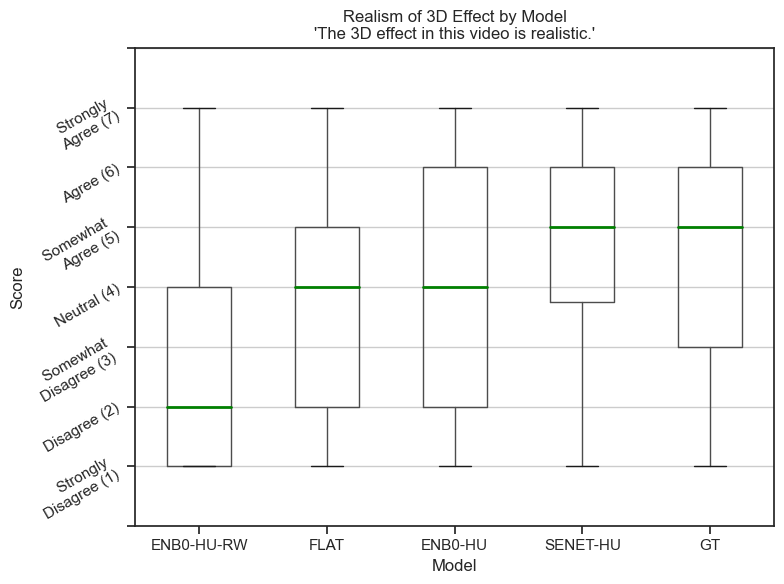

In [16]:
model_realism = dict()
statistical_test = []

for model in [Models.gt] + models:
    target_id = f"{model}"

    for video in videos:
        question_id = f"{target_id}-{video}-realism"

        scores = merged_realism_scores[question_id].copy()

        if target_id in model_realism:
            model_realism[target_id] = pd.concat((model_realism[target_id], scores), ignore_index=True)
        else:
            model_realism[target_id] = scores

kruskal_result = kruskal(*model_realism.values())
kruskal_result_text = f"Kruskal-Wallis H-test: H={kruskal_result.statistic:,.2f}, {format_p_value(kruskal_result.pvalue, 3)}"
print(kruskal_result_text)

with open(os.path.join(output_path, 'realism_model_kruskal.txt'), 'w') as f:
    f.write(kruskal_result_text)

all_models = models + [gt]
comparisons = [(i, j) for i in range(len(all_models) - 1) for j in range(i + 1, len(all_models))]
num_tests = len(comparisons)
print(f"Num Tests: {num_tests}")

model_a = []
median_a = []
model_b = []
median_b = []
statistics = []
p_values = []
significances = []

def compare_u_test(model_i, model_j):
    model_a_name = format_model_name(all_models[model_i])
    model_b_name = format_model_name(all_models[model_j])
    test_results = u_test(model_realism[all_models[model_i]], model_realism[all_models[model_j]])

    p_value = test_results.pvalue

    if p_value < alpha / num_tests:
        statistical_test.append(((model_i + 1, model_j + 1), p_value))

    model_a.append(model_a_name)
    median_a.append(np.median(model_realism[all_models[model_i]]))
    model_b.append(model_b_name)
    median_b.append(np.median(model_realism[all_models[model_j]]))
    statistics.append(test_results.statistic)
    p_values.append(test_results.pvalue)
    significances.append(p_value < alpha / num_tests)

for i, j in comparisons:
    compare_u_test(i, j)

stats_df = pd.DataFrame.from_dict({'Model A': model_a, 'Median A': median_a, 'Model B': model_b, 'Median B': median_b, 'U Statistic': statistics, 'P-Value': p_values, 'Significance': significances})

for column in ('U Statistic', 'Median A', 'Median B'):
    stats_df[column] = stats_df[column].astype(int)
    
caption = (f"Pairwise Mann-Whitney U test by model on realism. We apply Bonferroni correction which means the threshold for significance is {format_p_value(alpha/num_tests, precision=3)} ($\\alpha={format_p_value(alpha)}$, {num_tests} tests).", "Pairwise Statistical Tests by Model on Realism")
print(caption[0])
print(stats_df)

latex_table = stats_df.to_latex(formatters={'P-Value': format_p_value, 'U Statistic': "{:,d}", 'Median A': "{:.1f}", "Median B": "{:.1f}",  'Significance': lambda b: '\\cmark' if b else ''}, index=False, 
                                caption=caption)

with open(os.path.join(output_path, 'realism_model.tex'), 'w') as f:
    f.write(latex_table)

plot_realism_by_model(
    merged_realism_scores,
    output_path=os.path.join(output_path, 'realism_model.png'),
    statistical_test=None
)

The difference between models is much clearer when it comes to realism scores.

Not quite sure how to interpret the `statistic` part of the results, but the p-values seem to confirm the large differences we see in the plot above.


## Is There an Effect from Scene?
It depends on whether we are looking at the similarity scores, or the realism scores.

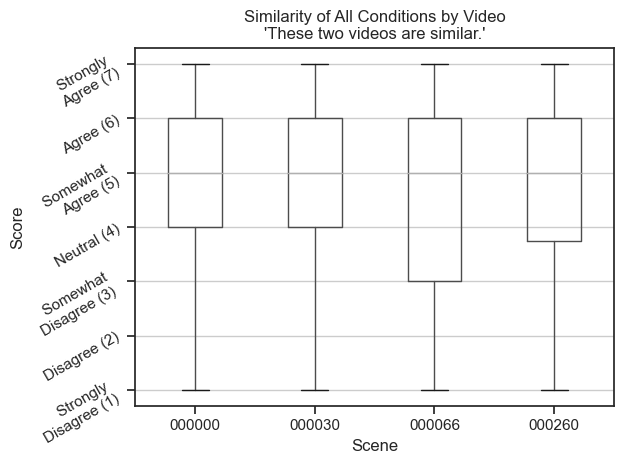

In [17]:
plot_similarity_scores_by_scene(similarity_scores, output_path=os.path.join(output_path, 'similarity_scene.png'))

In [18]:
video_similarity = dict()

for video in videos:
    target_id = f"{video}"

    for model in models:
        question_id = f"{gt}-{model}-{video}-similarity"

        scores = similarity_scores[question_id].copy()

        if target_id in video_similarity:
            video_similarity[target_id] = pd.concat((video_similarity[target_id], scores))
        else:
            video_similarity[target_id] = scores


video_similarity_df = video_similarity

for i in range(len(videos)):
    for j in range(i + 1, len(videos)):
        video1 = f"{videos[i]}"
        video2 = f"{videos[j]}"
        print(video1, video2)
        print(format_stat_test(u_test(video_similarity_df[video1], video_similarity_df[video2])))
        print()

000000 000030
Statistic:  3,260.00 - P-Value:  .83

000000 000066
Statistic:  3,758.00 - P-Value:  .05

000000 000260
Statistic:  3,463.50 - P-Value:  .36

000030 000066
Statistic:  3,642.50 - P-Value:  .12

000030 000260
Statistic:  3,390.50 - P-Value:  .51

000066 000260
Statistic:  2,937.50 - P-Value:  .36



Going off of the p-values, there does not seem to be a significant difference between ratings of different scenes when it comes to similarity.
This is what we would hope to see.

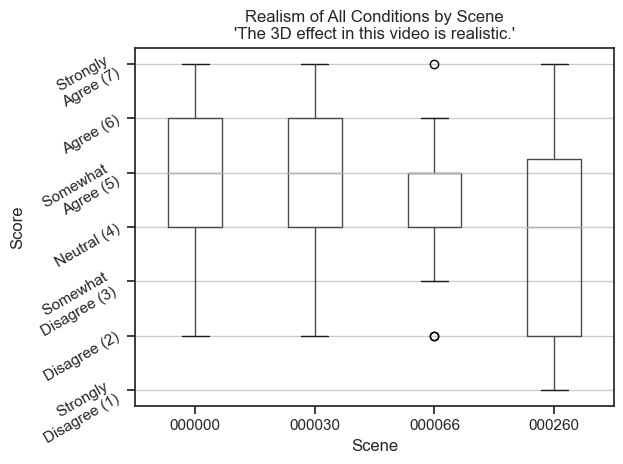

In [19]:
plot_realism_by_scene(merged_realism_scores, output_path=os.path.join(output_path, 'realism_scene.png'))

In [20]:
video_realism = dict()

for video in videos:
    target_id = f"{video}"

    for model in [gt] + models:
        question_id = f"{model}-{video}-realism"

        scores = merged_realism_scores[question_id].copy()

        if target_id in video_realism:
            video_realism[target_id] = pd.concat((video_realism[target_id], scores))
        else:
            video_realism[target_id] = scores


video_realism_df = video_realism

for i in range(len(videos)):
    for j in range(i + 1, len(videos)):
        video1 = f"{videos[i]}"
        video2 = f"{videos[j]}"
        print(video1, video2)
        print(format_stat_test(u_test(video_realism_df[video1], video_realism_df[video2])))
        print()

000000 000030
Statistic: 14,270.00 - P-Value:  .28

000000 000066
Statistic: 16,768.00 - P-Value: <.01

000000 000260
Statistic: 14,806.50 - P-Value: <.01

000030 000066
Statistic: 15,392.50 - P-Value:  .04

000030 000260
Statistic: 13,675.50 - P-Value:  .01

000066 000260
Statistic: 12,675.00 - P-Value:  .53



Unlike the similarity scores, most of the time there seems to be a significant difference between scenes when it comes to realism.